In [1]:
import os
import sys
import numpy as np
import torch

sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), "src")))


from data_loading.extract_indices import extract_trajectory_indices
from data_loading.load_data import load_dataset

os.environ["CUDA_VISIBLE_DEVICES"] = "6" 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_epochs = 100  # 학습 에폭 수
env_name = "box-close-v2"
# env_name = "sweep-v2"
# env_name = "button-press-topdown-v2"
# env_name = "dial-turn-v2"
exp_name = "classifier-test"
pair_algo = "ternary-500"
TRAJECTORY_LENGTH=25


dataset = load_dataset(env_name=env_name)
indices = extract_trajectory_indices(dataset)
cum_sum = np.cumsum(dataset["rewards"])
average_reward = np.mean(dataset["rewards"])
average_success = np.mean(dataset["success"])

success_traj = 0

for i, e in indices:
    success = dataset["success"][i:e].sum()
    if success > 0:
        success_traj += 1



print ("ENV", env_name)
print("average reward", average_reward)
print("average success", average_success)
print("success traj ratio", success_traj / len(indices))


trajectory counts 4800
ENV box-close-v2
average reward 1.0545156
average success 0.039954583333333335
success traj ratio 0.08041666666666666


In [2]:
def fill_feedback_from_raw_dataset(average_reward, cumulative_rewards, pairs):
    """
    Fill feedback in dataset using cumulative rewards and calculate mu values.
    """

    feedbacks = []

    for s0, s1 in pairs:
        sum_of_rewards_0 = cumulative_rewards[s0[1] - 1] - (
            cumulative_rewards[s0[0] - 1] if s0[0] > 0 else 0
        )
        sum_of_rewards_1 = cumulative_rewards[s1[1] - 1] - (
            cumulative_rewards[s1[0] - 1] if s1[0] > 0 else 0
        )

        if (
            np.abs(sum_of_rewards_0 - sum_of_rewards_1)
            < average_reward * TRAJECTORY_LENGTH * 0.1
        ):
            mu = 0.5
        else:
            mu = 0 if sum_of_rewards_0 > sum_of_rewards_1 else 1

        feedbacks.append((s0, s1, mu))

    return feedbacks


In [3]:
def generate_pairs_from_indices(trajectories, pair_count, trajectory_length):
    """
    choose pairs from indices and cut them to have a fixed length with same starting point
    """

    pairs = []
    valid_trajectories = [t for t in trajectories if (t[1] - t[0]) >= trajectory_length]
    total_trajectory_count = len(valid_trajectories)

    while len(pairs) < pair_count:
        first_pair_index, second_pair_index = np.random.randint(
            0, total_trajectory_count - 1, 2
        )

        first_trajectory = valid_trajectories[first_pair_index]
        second_trajectory = valid_trajectories[second_pair_index]
        min_length = min(
            (
                first_trajectory[1] - first_trajectory[0],
                second_trajectory[1] - second_trajectory[0],
            )
        )

        first_start_point = np.random.randint(1, min_length - trajectory_length)
        second_start_point = np.random.randint(1, min_length - trajectory_length)

        first_pair = (
            first_trajectory[0] + first_start_point,
            first_trajectory[0] + first_start_point + trajectory_length,
        )
        second_pair = (
            second_trajectory[0] + second_start_point,
            second_trajectory[0] + second_start_point + trajectory_length,
        )

        pairs.append((first_pair, second_pair))

    return pairs

In [4]:
from data_generation.utils import save_feedbacks_npz



# ✅ 학습 데이터 생성
train_pairs = generate_pairs_from_indices(
    trajectories=indices,
    pair_count=500,
    trajectory_length=25,
)

# ✅ 테스트 데이터 생성 
test_pairs = generate_pairs_from_indices(
    trajectories=indices,
    pair_count=100000,
    trajectory_length=25,
)

train_feedbacks = fill_feedback_from_raw_dataset(
    average_reward=average_reward,
    cumulative_rewards=cum_sum,
    pairs=train_pairs,
)

test_feedbacks = fill_feedback_from_raw_dataset(
    average_reward=average_reward,
    cumulative_rewards=cum_sum,
    pairs=test_pairs,
)

train_feedbacks_split = []
for feedback in train_feedbacks:
    s0, s1, mu = feedback

    possible_s0 = []
    possible_s1 = []

    possible_s0.append(s0)
    possible_s1.append(s1)

    possible_s0.append((s0[0] - 1, s0[1] - 1))
    possible_s0.append((s0[0] + 1, s0[1] + 1))
    possible_s1.append((s1[0] - 1, s1[1] - 1))
    possible_s1.append((s1[0] + 1, s1[1] + 1))

    for s0 in possible_s0:
        for s1 in possible_s1:
            train_feedbacks_split.append((s0, s1, mu))
            train_feedbacks_split.append((s1, s0, 1 - mu))
        
print(len(train_feedbacks_split))

train_split_pairs = [(s0, s1) for s0, s1, _ in train_feedbacks_split]
train_split_raw_feedbacks = fill_feedback_from_raw_dataset(
    average_reward=average_reward,
    cumulative_rewards=cum_sum,
    pairs=train_split_pairs,
)

train_split_correct = 0
for i, (s0, s1, mu) in enumerate(train_feedbacks_split):
    if train_split_raw_feedbacks[i][2] == mu:
        train_split_correct += 1

print("train split accuracy", train_split_correct / len(train_feedbacks_split))


# 학습 데이터
save_feedbacks_npz(
    env_name=env_name,
    exp_name=exp_name,
    pair_type="train",
    pair_name=pair_algo + "-split",
    feedbacks=train_feedbacks,
)

save_feedbacks_npz(
    env_name=env_name,
    exp_name=exp_name,
    pair_type="test",
    pair_name=pair_algo,
    feedbacks=test_feedbacks,
)

test_feedbacks_split = []

for feedback in test_feedbacks:
    s0, s1, mu = feedback

    possible_s0 = []
    possible_s1 = []

    possible_s0.append(s0)
    possible_s1.append(s1)

    possible_s0.append((s0[0] - 1, s0[1] - 1))
    possible_s0.append((s0[0] + 1, s0[1] + 1))
    possible_s1.append((s1[0] - 1, s1[1] - 1))
    possible_s1.append((s1[0] + 1, s1[1] + 1))

    for s0 in possible_s0:
        for s1 in possible_s1:
            test_feedbacks_split.append((s0, s1, mu))
            test_feedbacks_split.append((s1, s0, 1 - mu))
    
save_feedbacks_npz(
    env_name=env_name,
    exp_name=exp_name,
    pair_type="test",
    pair_name=pair_algo + "-split",
    feedbacks=test_feedbacks_split,
)




9000
train split accuracy 0.9942222222222222
Saved feedbacks at pair/box-close-v2/classifier-test/train/ternary-500-split.npz
Saved feedbacks at pair/box-close-v2/classifier-test/test/ternary-500.npz
Saved feedbacks at pair/box-close-v2/classifier-test/test/ternary-500-split.npz


In [5]:
from data_generation.classifier.trajectory_pair_classifier import train_trajectory_pair_classifier
from utils.path import get_trajectory_pair_classifier_path

batch_size = 32


model_path = get_trajectory_pair_classifier_path(
    env_name=env_name, exp_name=exp_name, pair_algo=pair_algo
)

if os.path.exists(model_path):
    print(f"Model already exists at {model_path}.")
    os.remove(model_path)


train_trajectory_pair_classifier(
    env_name=env_name,
    exp_name=exp_name,
    pair_algo=pair_algo+"-split",
    batch_size=batch_size,
    num_epochs=num_epochs,
    device=device,
)

Loaded pair/box-close-v2/classifier-test/train/ternary-500-split.npz dataset
Processed data with 500 samples


/home/sehyeok/jaewook/SPA/src/data_generation/classifier/trajectory_pair_classifier.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(mod

✅ Loaded existing model from model/box-close-v2/classifier-test/classifier/ternary-500-split/trajectory-pair-classifier.pth


Epoch 100/100: 100%|██████████| 16/16 [00:00<00:00, 319.93it/s]

✅ Model saved at model/box-close-v2/classifier-test/classifier/ternary-500-split/trajectory-pair-classifier.pth


In [6]:
from data_generation.classifier.trajectory_pair_classifier import TrajectoryPairClassifier
from data_loading.preference_dataloader import get_dataloader
from utils.path import get_trajectory_pair_classifier_path

model_path = get_trajectory_pair_classifier_path(
    env_name=env_name,
    exp_name=exp_name,
    pair_algo=pair_algo + "-split",
)

classifier = TrajectoryPairClassifier(input_dim=43*25).to(device)
classifier.load_state_dict(torch.load(model_path))
classifier.eval()

test_loader = get_dataloader(
        env_name=env_name,
        exp_name=exp_name,
        pair_type="test",
        pair_algo=pair_algo + "-split",
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
    )


/tmp/ipykernel_4078608/19075142.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load(model_path))


Loaded pair/box-close-v2/classifier-test/test/ternary-500-split.npz dataset
Processed data with 1800000 samples


In [7]:
from tqdm import tqdm

original_mu_list = []
predicted_mu_list = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating Model"):
        (
            s0_obs_batch,
            s0_act_batch,
            s1_obs_batch,
            s1_act_batch,
            mu_batch,
            _,
            _,
        ) = [x.to(device) for x in batch]

        batch_dim = s0_obs_batch.shape[0]

        s0_batch = torch.cat((s0_obs_batch, s0_act_batch), dim=-1).reshape(batch_dim, -1)
        s1_batch = torch.cat((s1_obs_batch, s1_act_batch), dim=-1).reshape(batch_dim, -1)
        batch = torch.cat((s0_batch, s1_batch), dim=-1)

        output = classifier(batch)
        predicted_mu = torch.sigmoid(output[:, 1])

        original_mu_list.append(mu_batch.cpu().numpy())
        predicted_mu_list.append(predicted_mu.cpu().numpy())

original_mu_array = np.concatenate(original_mu_list, axis=0)
predicted_mu_array = np.concatenate(predicted_mu_list, axis=0)

print (len(original_mu_array))
print (len(predicted_mu_array))


Evaluating Model: 100%|██████████| 56250/56250 [00:40<00:00, 1380.14it/s]


1800000
1800000


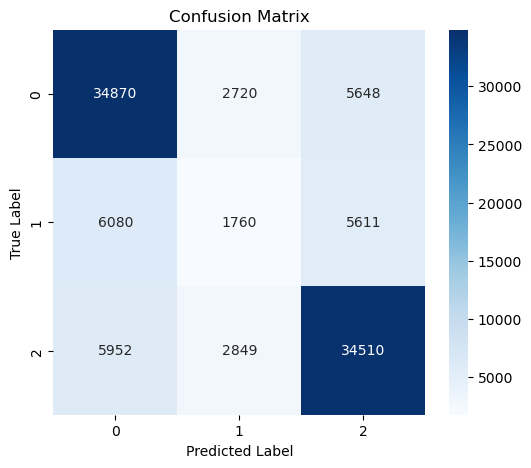

Accuracy: 71.14%


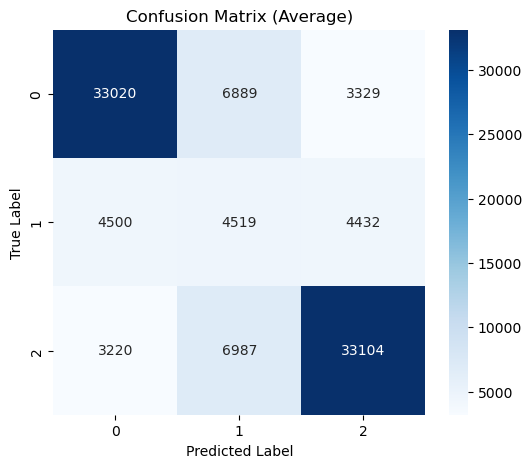

Accuracy (Average): 70.64%


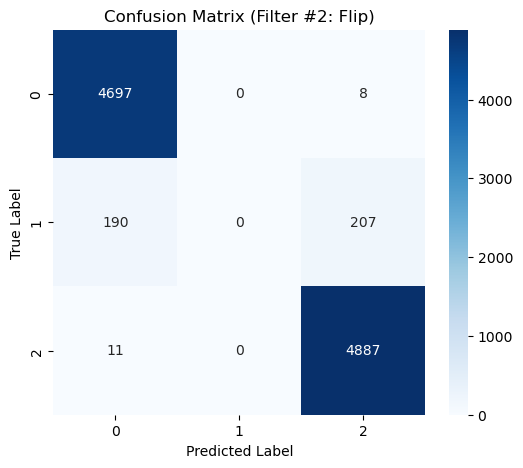

Accuracy (Filter #2 - Flip): 95.84%


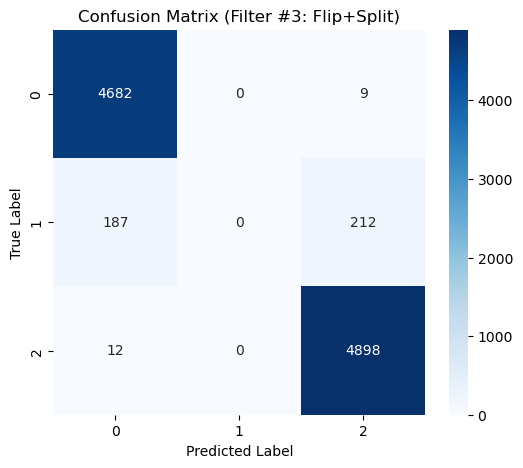

Accuracy (Filter #3 - Flip+Split): 95.80%


In [8]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def categorize_mu(mu_array):
    mu_classes = np.full_like(mu_array, 1, dtype=int)  # 기본값 1 (중립)
    mu_classes[mu_array < 1/3] = 0  # Class 0
    mu_classes[mu_array > 2/3] = 2  # Class 1
    return mu_classes

original_mu = []
predicted_mu = []
predicted_avg_mu = []

num_samples = len(original_mu_array) // 18

for i in range(num_samples):
    original_mu.append(original_mu_array[i * 18])
    predicted_mu.append(predicted_mu_array[i * 18])
    predicted_avg_mu.append((predicted_mu_array[i * 18] + (1 - predicted_mu_array[i * 18 + 1])) / 2)

original_mu = np.array(original_mu)
predicted_mu = np.array(predicted_mu)
predicted_avg_mu = np.array(predicted_avg_mu)


# 1. 그냥 정확도
cm1 = confusion_matrix(categorize_mu(original_mu), categorize_mu(predicted_mu), labels=[0, 1, 2])

plt.figure(figsize=(6, 5))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1", "2"], yticklabels=["0", "1", "2"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

correct_predictions = np.trace(cm1) 
total_predictions = np.sum(cm1)
accuracy = (correct_predictions / total_predictions) * 100 if total_predictions > 0 else 0

print(f"Accuracy: {accuracy:.2f}%")

cm1_avg = confusion_matrix(categorize_mu(original_mu), categorize_mu(predicted_avg_mu), labels=[0, 1, 2])

plt.figure(figsize=(6, 5))
sns.heatmap(cm1_avg, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1", "2"], yticklabels=["0", "1", "2"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Average)")
plt.show()

correct_predictions = np.trace(cm1_avg)
total_predictions = np.sum(cm1_avg)
accuracy = (correct_predictions / total_predictions) * 100 if total_predictions > 0 else 0

print(f"Accuracy (Average): {accuracy:.2f}%")

# 2. flip 필터 정확도
loss_pairs = []

for i in range(num_samples):
    pred = predicted_mu_array[i * 18:(i + 1) * 18]

    # mu = 0
    loss_0 = abs(pred[0] - 0) + abs(pred[1] - 1)
    loss_pairs.append((loss_0, i, 0))

    # mu = 1
    loss_1 = abs(pred[0] - 1) + abs(pred[1] - 0)
    loss_pairs.append((loss_1, i, 1))

    # mu = 0.5
    loss_half = abs(pred[0] - 0.5) + abs(pred[1] - 0.5)
    loss_pairs.append((loss_half, i, 0.5))

# 정렬 및 필터
loss_pairs.sort(key=lambda x: x[0])
top = loss_pairs[:10000]

original_mu_2 = []
predicted_mu_2 = []

for (loss, index, assumed_mu) in top:
    original_mu_2.append(original_mu[index])
    predicted_mu_2.append(assumed_mu)

original_mu_2 = np.array(original_mu_2)
predicted_mu_2 = np.array(predicted_mu_2)

cm2 = confusion_matrix(categorize_mu(original_mu_2), categorize_mu(predicted_mu_2), labels=[0, 1, 2])

plt.figure(figsize=(6, 5))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1", "2"], yticklabels=["0", "1", "2"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Filter #2: Flip)")
plt.show()

correct_predictions = np.trace(cm2) 
total_predictions = np.sum(cm2)
accuracy = (correct_predictions / total_predictions) * 100 if total_predictions > 0 else 0

print(f"Accuracy (Filter #2 - Flip): {accuracy:.2f}%")

# 3. flip + split 필터 정확도 
loss_pairs_split = []

for i in range(num_samples):
    pred = predicted_mu_array[i * 18:(i + 1) * 18]

    # mu = 0
    loss_0 = sum(abs(pred[j] - (0 if j % 2 == 0 else 1)) for j in range(18))
    loss_pairs_split.append((loss_0, i, 0))

    # mu = 1
    loss_1 = sum(abs(pred[j] - (1 if j % 2 == 0 else 0)) for j in range(18))
    loss_pairs_split.append((loss_1, i, 1))

    # mu = 0.5
    loss_half = sum(abs(pred[j] - 0.5) for j in range(18))
    loss_pairs_split.append((loss_half, i, 0.5))

# 정렬 및 필터
loss_pairs_split.sort(key=lambda x: x[0])
top_split = loss_pairs_split[:10000]

original_mu_3 = []
predicted_mu_3 = []

for (loss, index, assumed_mu) in top_split:
    original_mu_3.append(original_mu[index])
    predicted_mu_3.append(assumed_mu)

original_mu_3 = np.array(original_mu_3)
predicted_mu_3 = np.array(predicted_mu_3)

cm3 = confusion_matrix(categorize_mu(original_mu_3), categorize_mu(predicted_mu_3), labels=[0, 1, 2])

plt.figure(figsize=(6, 5))
sns.heatmap(cm3, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1", "2"], yticklabels=["0", "1", "2"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Filter #3: Flip+Split)")
plt.show()

correct_predictions = np.trace(cm3)
total_predictions = np.sum(cm3)
accuracy = (correct_predictions / total_predictions) * 100 if total_predictions > 0 else 0

print(f"Accuracy (Filter #3 - Flip+Split): {accuracy:.2f}%")